## Notebook: 01_eda_preprocessing.ipynb

## Purpose
This notebook performs **exploratory data analysis (EDA)** and **preprocessing setup** for the *PneumoDetect* project — a deep learning workflow for pneumonia detection on chest X-rays.

It focuses on understanding the dataset’s structure, class balance, image quality, and metadata before any model training begins.

---

## Objectives
1. **Load and inspect** the dataset (sample or full RSNA Pneumonia Detection subset).  
2. **Visualize class distribution** — pneumonia vs normal.  
3. **Display random montages** of X-rays for sanity checks.  
4. **Compute descriptive statistics** for image dimensions and intensity values.  
5. **Document observations** that guide later preprocessing and model design.  

---

## Key Steps
| Step | Description |
|------|--------------|
| **1. Load labels** | Reads the `train_labels_subset.csv` into a Pandas DataFrame. |
| **2. Data overview** | Displays data types, missing values, and sample rows. |
| **3. Label distribution** | Uses `seaborn.countplot()` to visualise pneumonia vs normal counts. |
| **4. Random montage** | Loads and plots 3×3 grid of random X-rays using `pydicom` and `matplotlib`. |
| **5. Image statistics** | Samples image shapes and pixel intensity ranges. |
| **6. Documentation** | Summarises findings in Markdown: class imbalance, size variance, grayscale range. |

---

## Observations (Typical)
- **Class ratio:** 0 ≈ 75 %, 1 ≈ 25 % (imbalanced — requires weighted loss).  
- **Image size:** Ranges from 1024×1024 to 2048×2048.  
- **Pixel intensity:** 12-bit grayscale (0–4096). Normalize to `[0, 1]`.  
- **Visual quality:** Pneumonia cases show local opacity, normal lungs appear uniformly translucent.

---

## Dependencies
Ensure these libraries are available in your Conda environment:
```bash
pandas
matplotlib
seaborn
pydicom
opencv-python
numpy
````

If missing, install them:

```bash
pip install pandas matplotlib seaborn pydicom opencv-python numpy
```

---

## Expected Input

```
data/
├── rsna_subset/
│   ├── train_images/          # 2 000 sampled .dcm files
│   └── train_labels_subset.csv
```

---

## Output Artifacts

| Output                           | Description                                             |
| -------------------------------- | ------------------------------------------------------- |
| `figures/label_distribution.png` | Class distribution bar chart                            |
| `figures/random_montage.png`     | Montage of random X-rays                                |
| Markdown cell summary            | Recorded class ratio, image size stats, intensity range |

---

## Notes

* Use this notebook **before model training** to ensure preprocessing is grounded in actual data properties.
* Save all visualisations in a `/figures/` folder for later inclusion in reports.
* Findings here inform choices for resizing, normalization, and class weighting in subsequent notebooks.

---

**Author:** Adrian Adewunmi
**Project:** AI-Assisted Pneumonia Detection (`PneumoDetect`)
**Date:** Week 1, Day 2 (W1-D2)


In [ ]:
# Load sample label CSV into pandas DataFrame

import pandas as pd
from pathlib import Path

# Define the path to the CSV file
label_path = Path("../data/rsna_subset/stage_2_train_labels.csv")

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(label_path)

# Display the first few rows of the DataFrame
print(df.head())
print(df.info())

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


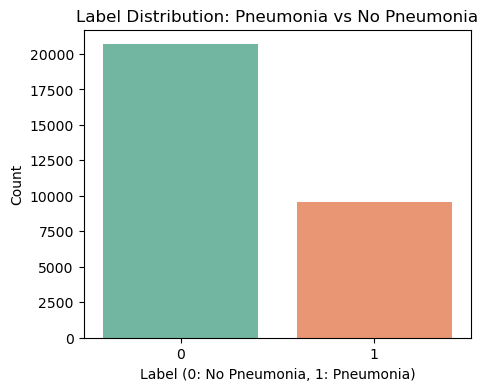

Class ratio (Pneumonia:No Pneumonia): {0: 0.6838918847388097, 1: 0.3161081152611903}


In [13]:
# Plot label distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.countplot(x='Target', hue='Target', data=df, palette='Set2', legend=False)
plt.title('Label Distribution: Pneumonia vs No Pneumonia')
plt.xlabel('Label (0: No Pneumonia, 1: Pneumonia)')
plt.ylabel('Count')
plt.show()

ratio = df['Target'].value_counts(normalize=True)
print('Class ratio (Pneumonia:No Pneumonia):', ratio.to_dict())

In [21]:
# Check CSV and image directory consistency

from pathlib import Path
import pandas as pd

df = pd.read_csv("../data/rsna_subset/stage_2_train_labels.csv")
img_dir = Path("../data/rsna_subset/train_images")

# Strip extensions from files for comparison
available_ids = {p.stem for p in img_dir.glob("*.dcm")}
missing = [pid for pid in df["patientId"].unique() if pid not in available_ids]

print(f"Images found: {len(available_ids)}")
print(f"Labels in CSV: {df['patientId'].nunique()}")
print(f"Missing matches: {len(missing)} ({len(missing)/len(df):.2%})")
print("Example missing IDs:", missing[:10])




Images found: 2000
Labels in CSV: 26684
Missing matches: 24684 (81.66%)
Example missing IDs: ['0004cfab-14fd-4e49-80ba-63a80b6bddd6', '00313ee0-9eaa-42f4-b0ab-c148ed3241cd', '00322d4d-1c29-4943-afc9-b6754be640eb', '003d8fa0-6bf1-40ed-b54c-ac657f8495c5', '00436515-870c-4b36-a041-de91049b9ab4', '00569f44-917d-4c86-a842-81832af98c30', '006cec2e-6ce2-4549-bffa-eadfcd1e9970', '00704310-78a8-4b38-8475-49f4573b2dbb', '008c19e8-a820-403a-930a-bc74a4053664', '009482dc-3db5-48d4-8580-5c89c4f01334']


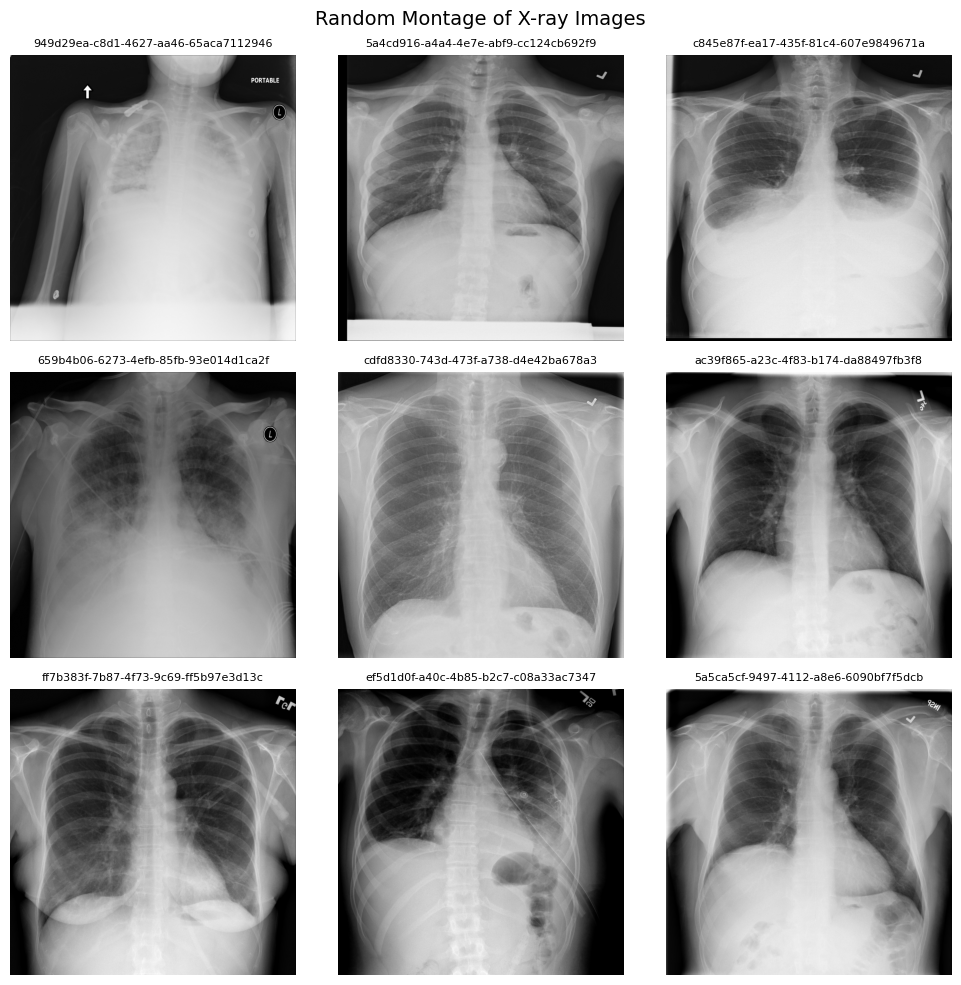

In [22]:
# Only display a random montage of X-ray images if files are available

import random
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

img_dir = Path("../data/rsna_subset/train_images")
available_files = list(img_dir.glob("*.dcm"))

if not available_files:
    print("No DICOM files found in", img_dir)
else:
    sample_files = random.sample(available_files, min(9, len(available_files)))

    plt.figure(figsize=(10, 10))
    for i, path in enumerate(sample_files):
        img = pydicom.dcmread(path).pixel_array
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(path.stem, fontsize=8)

    plt.suptitle("Random Montage of X-ray Images", fontsize=14)
    plt.tight_layout()
    plt.show()
